In [1]:
import math
import os
import sys
# from datetime import datetime
import pandas as pd
import numpy as np
import xarray as xr
import pickle
import netCDF4 as nc
import datetime
import geopandas as gpd
import rasterio
import fiona
import rioxarray
from shapely.geometry import mapping
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

sys.path.append('D:\\mehdi\\WaterBalance_new\\')
from qdwb.evapotranspiration.et import *
from qdwb.evapotranspiration.asset import *
from qdwb.evapotranspiration.convert import *
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.primary_surface_flow.check import *
from qdwb.soil_content.soil_layers import *
from qdwb.coordinate.extract import *

In [2]:
data_path = "D:\\mehdi\\DailyData\\Data\\"

# list of name of files in folder
def list_of_files(data_path):    
    files = os.listdir(data_path)
    return files

all_list_files = list_of_files(data_path)


# PET

In [3]:
para = ["P", "Tmin", "Tmax"]

list_files = {}

for p in para:
    
    tmp = pd.DataFrame(
        {
            "file": [x for x in all_list_files if x.startswith(p)],
            "year": [int(x.split("_")[1][0:4]) for x in all_list_files if x.startswith(p)]
        }
        
    )
    
    tmp.sort_values(by = "year", inplace = True)
    
    list_files[p] = tmp



In [4]:
def generate_date(x, year):
    
    if math.isnan(x):
        return "nan"
    else:
        return f"{year}-{int(x):02d}-01"

In [5]:
def mask_xarray(
   array,
   shapefile_basins
):
   
   shapefile_basins = shapefile_basins.to_crs("epsg:4326")
   shapefile_basins.crs = {'init': 'epsg:4326'}
   array.rio.write_crs("epsg:4326", inplace=True)
   clipped = array.rio.clip(shapefile_basins.geometry.apply(mapping), shapefile_basins.crs)
   # clipped.data = np.where(clipped.data == -9.99900e+03, np.nan, clipped.data)
    
   return clipped

# import data

In [6]:

shp_dir = r"D:\mehdi\DailyData\cal\subregions_C2VSim_California.shp"
shapefile_basins = gpd.read_file(shp_dir)

# shapefile_basins = shapefile_basins.loc[shapefile_basins['SubRegion'] == 1]


pickle_land_use = open(r"D:\mehdi\DailyData\land_use_4326.pkl","rb")
land_use_initial = pd.read_pickle(pickle_land_use)

land_use_initial["Total"].data = np.where(land_use_initial["Total"].data == 0.0, np.nan, land_use_initial["Total"].data)
land_use = mask_xarray(array = land_use_initial, shapefile_basins = shapefile_basins)
land_use = land_use.rename({'x': 'lon','y': 'lat'})

wp = xr.open_dataset("D:\mehdi\DailyData\wilting_point_1979001.nc")
wp = wp.rename({'x': 'lon','y': 'lat'})
wp = mask_xarray(array = wp, shapefile_basins = shapefile_basins)

fc = xr.open_dataset("D:\mehdi\DailyData\coefficient_field_capacity_1979001.nc")
fc = fc.rename({'x': 'lon','y': 'lat'})
fc = mask_xarray(array = fc, shapefile_basins = shapefile_basins)

cn = xr.open_dataset("D:\mehdi\DailyData\curve_number_1979001.nc")
cn = cn.fillna(0)
cn = cn.rename({'x': 'lon','y': 'lat'})
cn = mask_xarray(array = cn, shapefile_basins = shapefile_basins)

lu = xr.open_dataset("D:\mehdi\DailyData\land_use_fao_2022001.nc")
lu = lu.fillna(0)
lu = mask_xarray(array = lu, shapefile_basins = shapefile_basins)
lu = lu.rename({'x': 'lon','y': 'lat'})

lithology = xr.open_dataset("D:\mehdi\DailyData\lithology_2022001.nc")
# lithology = lithology.rename({'x': 'lon','y': 'lat'})
lithology = mask_xarray(array = lithology, shapefile_basins = shapefile_basins)
lithology = lithology.rename({'x': 'lon','y': 'lat'})


rsa = xr.open_dataset("D:\mehdi\DailyData\RSA_C2VSim_California.nc")
# rsa.rsa_final_geometric_mean[0].data
rsa = mask_xarray(array = rsa, shapefile_basins = shapefile_basins)
rsa = rsa.rename({'x': 'lon','y': 'lat'})

In [7]:
def myPlot(x, p, y, j):
    plt.figure(figsize=(10, 6))
    x.plot()
    plt.savefig(f'export/cal_budyko/plot/{p}_{y}_{j}.png')

In [8]:
def budyko(pet, p):
    # from Budyko 1958
    # p,pet = X
    if p == 0:
        x = 0
    else:
        x = np.sqrt(((pet/p)*np.tanh(p/pet))*(1-np.exp(-pet/p)))
    return x

In [10]:
selected_years = list(range(1993,2023))
# selected_years = [2010, 2011]
path_export_data = "D:\\mehdi\\DailyData\\export\\cal_budyko\\"

dp_year = []
p_year = []
irr_year = []
r_year = []
e_year = []
et_year = []
dp_budyko_year = []
e_budyko_year = []
et_budyko_year = []
irr_budyko_year = []
r_budyko_year = []
deltas = []
deltas_budyko = []

for year in selected_years:
    
    p1 = rioxarray.open_rasterio(f"{data_path}{list_files['P'][list_files['P']['year'] == year]['file'].values[0]}")
    p1 = mask_xarray(array = p1, shapefile_basins = shapefile_basins)
    p1.data = np.where(p1.data == -9.999e+03, np.nan, p1.data)
    p1.name = 'precipitation'
    Pre = p1.to_dataset()
    Pre = Pre.rename({'x': 'lon','y': 'lat'})
    
    
    # Tmin = xr.open_dataset(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    t1 = rioxarray.open_rasterio(f"{data_path}{list_files['Tmin'][list_files['Tmin']['year'] == year]['file'].values[0]}")
    t1 = mask_xarray(array = t1, shapefile_basins = shapefile_basins)
    t1.data = np.where(t1.data == -9.99900e+03, np.nan, t1.data)
    t1.name = 'air_temperature'
    Tmin = t1.to_dataset()
    Tmin = Tmin.rename({'x': 'lon','y': 'lat'})
    
    
    t2 = rioxarray.open_rasterio(f"{data_path}{list_files['Tmax'][list_files['Tmax']['year'] == year]['file'].values[0]}")
    t2 = mask_xarray(array = t2, shapefile_basins = shapefile_basins)
    t2.data = np.where(t2.data == -9.99900e+03, np.nan, t2.data)
    t2.name = 'air_temperature'
    Tmax = t2.to_dataset() 
    Tmax = Tmax.rename({'x': 'lon','y': 'lat'})
    
    lat = np.repeat(Tmin.lat, Tmin.lon.size).values.reshape(Tmin.lat.size, Tmin.lon.size)    
    lon = np.repeat(Tmin.lon, Tmin.lat.size).values.reshape(Tmin.lat.size, Tmin.lon.size)
    
    tmpDataArray = Tmin.copy(deep = True)
    tmpDataArray = tmpDataArray.rename({'air_temperature': 'temp'})
    tmpDataArray["temp"].values = np.empty(shape=tmpDataArray["temp"].shape)
        
    Ra = tmpDataArray.copy(deep = True)    
    Ra = Ra.rename({'temp': 'extraterrestrial_radiation'})
    
    ET = tmpDataArray.copy(deep = True)    
    ET = ET.rename({'temp': 'et_hargreaves_samani'})
    
    TE = tmpDataArray.copy(deep = True)    
    TE = TE.rename({'temp': 'total_evaporable_water'})
    
    MRF = tmpDataArray.copy(deep = True)    
    MRF = MRF.rename({'temp': 'moisture_reduction_function'})
    
    f_adjusted = tmpDataArray.copy(deep = True)    
    f_adjusted = f_adjusted.rename({'temp': 'moisture_reduction_function'})
    
    ET_actual = tmpDataArray.copy(deep = True)    
    ET_actual = ET_actual.rename({'temp': 'actual_evapotranspiration'})
    
    K_E = tmpDataArray.copy(deep = True)    
    K_E = K_E.rename({'temp': 'available_evaporable_water'})
    
    E_actual = tmpDataArray.copy(deep = True)    
    E_actual = E_actual.rename({'temp': 'actual_evaporation'})
    
    ET_total_actual = tmpDataArray.copy(deep = True)    
    ET_total_actual = ET_total_actual.rename({'temp': 'total_actual_evapotranspiration'})
    
    RUN_OFF = tmpDataArray.copy(deep = True)    
    RUN_OFF = RUN_OFF.rename({'temp': 'runoff'})
    
    INFILTRATION = tmpDataArray.copy(deep = True)    
    INFILTRATION = INFILTRATION.rename({'temp': 'infiltration'})
    
    CROP_COEFFICIENT = tmpDataArray.copy(deep = True)    
    CROP_COEFFICIENT = CROP_COEFFICIENT.rename({'temp': 'crop_coefficient'})
    
    SWC_EVAPORATION = tmpDataArray.copy(deep = True)    
    SWC_EVAPORATION = SWC_EVAPORATION.rename({'temp': 'current_swc_evaporation_layer'})
    
    SWC_TRANSPIRATION = tmpDataArray.copy(deep = True)    
    SWC_TRANSPIRATION = SWC_TRANSPIRATION.rename({'temp': 'current_swc_transpiration_layer'})
    
    SWC_TRANSITION = tmpDataArray.copy(deep = True)    
    SWC_TRANSITION = SWC_TRANSITION.rename({'temp': 'current_swc_transition_layer'})
    
    EVAPORATION_TO_TRANSPIRATION = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSPIRATION = EVAPORATION_TO_TRANSPIRATION.rename({'temp': 'current_evaporation_layer_to_transpiration_layer'})
    
    EVAPORATION_TO_TRANSITION = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSITION = EVAPORATION_TO_TRANSITION.rename({'temp': 'current_evaporation_layer_to_transition_layer'})
    
    TRANSPIRATION_TO_TRANSITION = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_TO_TRANSITION = TRANSPIRATION_TO_TRANSITION.rename({'temp': 'current_transpiration_layer_to_transition_layer'})
    
    TRANSPIRATION_ADJUSTED = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_ADJUSTED = TRANSPIRATION_ADJUSTED.rename({'temp': 'transpiration'})
    
    EVAPORATION_ADJUSTED = tmpDataArray.copy(deep = True)    
    EVAPORATION_ADJUSTED = EVAPORATION_ADJUSTED.rename({'temp': 'evaporation'})
    
    IRRIGATION_REQUIREMENT = tmpDataArray.copy(deep = True)    
    IRRIGATION_REQUIREMENT = IRRIGATION_REQUIREMENT.rename({'temp': 'irrigation_requirement'})
    
    DEEP_PERCOLATION = tmpDataArray.copy(deep = True)    
    DEEP_PERCOLATION = DEEP_PERCOLATION.rename({'temp': 'deepPercolation'})
    
    AET_BUDYKO = tmpDataArray.copy(deep = True)    
    AET_BUDYKO = AET_BUDYKO.rename({'temp': 'actual_total_evapotranspiration_budyko'})
    
    ET_actual_budyko = tmpDataArray.copy(deep = True)    
    ET_actual_budyko = ET_actual_budyko.rename({'temp': 'actual_evapotranspiration_budyko'})
    
    E_actual_budyko = tmpDataArray.copy(deep = True)    
    E_actual_budyko = E_actual_budyko.rename({'temp': 'actual_evaporation_budyko'})
    
    RUN_OFF_BUDYKO = tmpDataArray.copy(deep = True)    
    RUN_OFF_BUDYKO = RUN_OFF_BUDYKO.rename({'temp': 'runoff_budyko'})
    
    SWC_EVAPORATION_BUDYKO = tmpDataArray.copy(deep = True)    
    SWC_EVAPORATION_BUDYKO = SWC_EVAPORATION_BUDYKO.rename({'temp': 'current_swc_evaporation_layer_budyko'})
    
    SWC_TRANSPIRATION_BUDYKO = tmpDataArray.copy(deep = True)    
    SWC_TRANSPIRATION_BUDYKO = SWC_TRANSPIRATION_BUDYKO.rename({'temp': 'current_swc_transpiration_layer_budyko'})
    
    SWC_TRANSITION_BUDYKO = tmpDataArray.copy(deep = True)    
    SWC_TRANSITION_BUDYKO = SWC_TRANSITION_BUDYKO.rename({'temp': 'current_swc_transition_layer_budyko'})
    
    EVAPORATION_TO_TRANSPIRATION_BUDYKO = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSPIRATION_BUDYKO = EVAPORATION_TO_TRANSPIRATION_BUDYKO.rename({'temp': 'current_evaporation_layer_to_transpiration_layer_budyko'})
    
    EVAPORATION_TO_TRANSITION_BUDYKO = tmpDataArray.copy(deep = True)    
    EVAPORATION_TO_TRANSITION_BUDYKO = EVAPORATION_TO_TRANSITION_BUDYKO.rename({'temp': 'current_evaporation_layer_to_transition_layer_budyko'})
    
    TRANSPIRATION_TO_TRANSITION_BUDYKO = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_TO_TRANSITION_BUDYKO = TRANSPIRATION_TO_TRANSITION_BUDYKO.rename({'temp': 'current_transpiration_layer_to_transition_layer_budyko'})
    
    TRANSPIRATION_ADJUSTED_BUDYKO = tmpDataArray.copy(deep = True)    
    TRANSPIRATION_ADJUSTED_BUDYKO = TRANSPIRATION_ADJUSTED_BUDYKO.rename({'temp': 'transpiration_budyko'})
    
    EVAPORATION_ADJUSTED_BUDYKO = tmpDataArray.copy(deep = True)    
    EVAPORATION_ADJUSTED_BUDYKO = EVAPORATION_ADJUSTED_BUDYKO.rename({'temp': 'evaporation_budyko'})
    
    IRRIGATION_REQUIREMENT_BUDYKO = tmpDataArray.copy(deep = True)    
    IRRIGATION_REQUIREMENT_BUDYKO = IRRIGATION_REQUIREMENT_BUDYKO.rename({'temp': 'irrigation_requirement_budyko'})
    
    DEEP_PERCOLATION_BUDYKO = tmpDataArray.copy(deep = True)    
    DEEP_PERCOLATION_BUDYKO = DEEP_PERCOLATION_BUDYKO.rename({'temp': 'deepPercolation_budyko'})
    
    DELTA_S = tmpDataArray.copy(deep = True)    
    DELTA_S = DELTA_S.rename({'temp': 'bilan'})
    
    DELTA_S_BUDYKO = tmpDataArray.copy(deep = True)    
    DELTA_S_BUDYKO = DELTA_S_BUDYKO.rename({'temp': 'bilan_budyko'})
    
    for j_day in range(1, Tmin.time.size + 1):
        
        print(year, j_day)
        
        if year == selected_years[0] and j_day == 1:
            swc = xr.open_dataset("D:\mehdi\DailyData\soil_water_content_1979001.nc")        
            swc = swc.fillna(0)
            
            soil_water_content = mask_xarray(array = swc, shapefile_basins = shapefile_basins)
            soil_water_content = soil_water_content.rename({'x': 'lon','y': 'lat'})
            
            soil_water_content_evaporation = soil_water_content["volumetric_soil_water_layer_1"].sel(time = "1979-01-01")[:, :].data
            soil_water_content_transpiration = soil_water_content["volumetric_soil_water_layer_2"] + soil_water_content["volumetric_soil_water_layer_3"]
            soil_water_content_transpiration = soil_water_content_transpiration.sel(time = "1979-01-01")[:, :].data
            soil_water_content_transition = soil_water_content["volumetric_soil_water_layer_4"].sel(time = "1979-01-01")[:, :].data
            
            
            
            constant_value_for_AE = 29
            # AE = xr.Dataset(
            #     data_vars={
            #         "available_evaporable_water": (("time", "lat", "lon"), np.full((len(soil_water_content.time), len(soil_water_content.lat), len(soil_water_content.lon)), constant_value_for_AE))
            #     },
            #     coords={
            #         "lat": soil_water_content.lat,
            #         "lon": soil_water_content.lon,
            #         "time": soil_water_content.time
            #     },
            # )
            # AE = AE.to_array()
            
            AE = np.zeros((len(soil_water_content.lat), len(soil_water_content.lon))) + constant_value_for_AE
                    
        else:
            
            soil_water_content_evaporation = soil_water_content_day[0][0]
            soil_water_content_evaporation = np.vectorize(lambda d: 0 if np.isnan(d) else d)(
                d = soil_water_content_evaporation
            )
            soil_water_content_transpiration = soil_water_content_day[1][0]
            soil_water_content_transpiration = np.vectorize(lambda d: 0 if np.isnan(d) else d)(
                d = soil_water_content_transpiration
            )
            soil_water_content_transition = soil_water_content_day[2][0]
            soil_water_content_transition = np.vectorize(lambda d: 0 if np.isnan(d) else d)(
                d = soil_water_content_transition
            )
            
            # TODO: AE???
            # e_actual_day
            # run_off_and_infiltration_day[1]
            
            AE = np.vectorize(available_evaporable_water)(
                e_a = soil_water_content_day[7][0],
                infiltration = infiltration_day,
                available_evaporable_water_in_previous_step = available_evaporable_water_day
            )
            

        
        date_object = datetime.datetime.strptime(f"{year}{j_day}", '%Y%j').date()
        model_date = date_object.strftime("%Y-%m-%d")
        
        pre_day = Pre.to_array()[0, j_day - 1, :, :]
        # myPlot(pre_day, "pre", year, j_day)      
        
        Tmin_day = Tmin.to_array()[0, j_day - 1, :, :]
        # myPlot(Tmin_day, "Tmin", year, j_day)
        
        Tmax_day = Tmax.to_array()[0, j_day - 1, :, :]
        # myPlot(Tmax_day, "Tmax", year, j_day)
        
        Tmean_day = (Tmin_day + Tmax_day) / 2
        # myPlot(Tmean_day, "Tmean", year, j_day)
        
        ra_day = np.vectorize(extraterrestrial_radiation)(
            inverse_relative_distance_earth_sun(
                julian_date = j_day
            ),
            sunset_hour_angle(
                latitude=convert_degrees2radians(lat),
                solar_declination = solar_declination(
                    julian_date = j_day
                )
            ),
            convert_degrees2radians(
                degrees = lat
            ),
            solar_declination(
                julian_date = j_day
            )            
        )
        
        
        Ra["extraterrestrial_radiation"][j_day - 1, :, :] = ra_day
        # myPlot(Ra["extraterrestrial_radiation"][j_day - 1], "Ra", year, j_day)
                
        et_day_hargreaves_samani = np.vectorize(ReferenceEvapotranspiration.hargreaves_samani)(
            tmin = Tmin_day,
            tmax = Tmax_day,
            tmean = Tmean_day,
            ra = ra_day
        )
        et_day_hargreaves_samani = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = et_day_hargreaves_samani
        )
        
        
        ET["et_hargreaves_samani"][j_day - 1, :, :] = et_day_hargreaves_samani
        # myPlot(ET["et_hargreaves_samani"][j_day - 1], "et_day_hargreaves_samani", year, j_day)
        
        ratio_day_budyko = np.vectorize(budyko)(
            pet = et_day_hargreaves_samani,
            p = pre_day
        )
        
        aet_day_budyko = np.vectorize(lambda r, p: r * p)(
            r = ratio_day_budyko,
            p = pre_day
        )
        
        AET_BUDYKO["actual_total_evapotranspiration_budyko"][j_day - 1, :, :] = aet_day_budyko
        # myPlot(AET_BUDYKO["actual_total_evapotranspiration_budyko"][j_day - 1], "actual_total_evapotranspiration_budyko", year, j_day)
        
        # factor = 0.44
        et_actual_budyko_day = np.vectorize(lambda d, factor: d * (1 / (1 + factor)))(
            d = aet_day_budyko,
            factor = lu["crop cover"].sel(time = "2022-01-01")
        )
        
        e_actual_budyko_day = np.vectorize(lambda d, factor: d * (factor / (1 + factor)))(
            d = aet_day_budyko,
            factor = lu["crop cover"].sel(time = "2022-01-01")
        )
        
        ET_actual_budyko["actual_evapotranspiration_budyko"][j_day - 1, :, :] = et_actual_budyko_day
        E_actual_budyko["actual_evaporation_budyko"][j_day - 1, :, :] = e_actual_budyko_day
        
        # myPlot(ET_actual_budyko["actual_evapotranspiration_budyko"][j_day - 1], "actual_evapotranspiration_budyko", year, j_day)
        # myPlot(E_actual_budyko["actual_evaporation_budyko"][j_day - 1], "actual_evaporation_budyko", year, j_day)
        
        
        
        total_evaporable_water_day = np.vectorize(available_water)(
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000
        )
        

        
        TE["total_evaporable_water"][j_day - 1, :, :] = total_evaporable_water_day
        # myPlot(TE["total_evaporable_water"][j_day - 1], "total_evaporable_water_day", year, j_day)
        
        
        
        f_day = np.vectorize(moisture_reduction_function)(
            soil_wetness_in_previous_step = soil_water_content_transpiration,
            permanent_wilting_point_wet = wp["b0"].sel(time = "1979-01-01")[:, :],
            field_capacity_wet = fc["b0"].sel(time = "1979-01-01")[:, :],
            soil_depth = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000
        )
        
        # FIXME: soil_water_content_transpiration 
        
        MRF["moisture_reduction_function"][j_day - 1, :, :] = f_day
        
        f_adjusted_day = np.vectorize(lambda d: 0 if d < 0 else d)(
            d = f_day
        )
        
        
        f_adjusted["moisture_reduction_function"][j_day - 1, :, :] = f_adjusted_day
        # myPlot(f_adjusted["moisture_reduction_function"][j_day - 1], "f_adjusted_day", year, j_day)
        
        plant_date_day = np.vectorize(generate_date)(
            x = land_use['Plant Date'].sel(time = "2022-01-01")[:,:],
            year = year
        )
        plant_date_day = np.where(plant_date_day == "nan", pd.NA, plant_date_day)        
        # plant_date_day = np.where(pd.isnull(plant_date_day), np.nan, plant_date_day)
        plant_date_day = np.where(pd.isnull(plant_date_day), "1960-01-01", plant_date_day)
        
        crop_coefficient_day = np.vectorize(PotentialEvapotranspiration.calculate_single_crop_coefficient_for_linear_changes_steps)(
            crop_coefficient_ini = land_use["Kc init"].sel(time = "2022-01-01")[:,:],
            crop_coefficient_mid = land_use["Kc mid"].sel(time = "2022-01-01")[:,:],
            crop_coefficient_end = land_use["Kc end"].sel(time = "2022-01-01")[:,:],
            length_ini_crop = land_use["Init. (Lini)"].sel(time = "2022-01-01")[:,:],
            length_dev_crop = land_use["Dev. (Ldev)"].sel(time = "2022-01-01")[:,:],
            length_mid_crop = land_use["Mid (Lmid)"].sel(time = "2022-01-01")[:,:],
            length_late_crop = land_use["Late (Llate)"].sel(time = "2022-01-01")[:,:],
            plant_date = plant_date_day[:,:],
            modeling_date = model_date
        )
        
        CROP_COEFFICIENT["crop_coefficient"][j_day - 1, :, :] = crop_coefficient_day
        # myPlot(CROP_COEFFICIENT["crop_coefficient"][j_day - 1], "crop_coefficient_day", year, j_day)
        
         
        et_actual_day = np.vectorize(ActualEvapotranspiration.et_covered)(
            moisture_reduction_function = f_adjusted_day,
            crop_coefficient = CROP_COEFFICIENT["crop_coefficient"].sel(time = model_date)[:,:],
            crop_cover = lu["crop cover"].sel(time = "2022-01-01"),
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )

        ET_actual["actual_evapotranspiration"][j_day - 1, :, :] = et_actual_day[0]
        # myPlot(ET_actual["actual_evapotranspiration"][j_day - 1], "et_actual_day", year, j_day)
        
        available_evaporable_water_day = AE
        # available_evaporable_water_day = AE[:, :]
        
        k_e_day = np.vectorize(ratio_of_actual_evaporable_water_to_total_evaporable_water)(
            available_water = total_evaporable_water_day,
            available_evaporable_water = available_evaporable_water_day
        )
        
        K_E["available_evaporable_water"][j_day - 1, :, :] = k_e_day
        # myPlot(K_E["available_evaporable_water"][j_day - 1], "k_e_day", year, j_day)
        
        
        e_actual_day = np.vectorize(ActualEvapotranspiration.e_noncovered)(
            ratio_of_actual_evaporable_water_to_total_evaporable_water = k_e_day,
            crop_cover = lu["crop cover"].sel(time = "2022-01-01"),
            reference_crop_evapotranspiration = et_day_hargreaves_samani
        )
        
        
        E_actual["actual_evaporation"][j_day - 1, :, :] = e_actual_day
        # myPlot(E_actual["actual_evaporation"][j_day - 1], "e_actual_day", year, j_day)
        
        et_total_actual_day = np.vectorize(ActualEvapotranspiration.et_QDWB)(
            evaporation_noncovered_areas = e_actual_day,
            evapotranspiration_covered_areas = et_actual_day
        )
        
        
        ET_total_actual["total_actual_evapotranspiration"][j_day - 1, :, :] = et_total_actual_day[0]
        # myPlot(ET_total_actual["total_actual_evapotranspiration"][j_day - 1], "et_total_actual_day", year, j_day)
        
        model_date_array = np.array([datetime.datetime.strptime(model_date, '%Y-%m-%d')] * plant_date_day.shape[0] * plant_date_day.shape[1]).reshape(plant_date_day.shape[0], plant_date_day.shape[1])
        plant_date_day_array = np.vectorize(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))(
            d = plant_date_day
        )
        total_adjusted = np.where(np.isnan(land_use["Total"][0].data), 0 , land_use["Total"][0].data)
        
        end_date_of_growing = np.vectorize(lambda x , y: x + datetime.timedelta(days=y))(
            x = plant_date_day_array,
            y = total_adjusted
        )
        growing_season = np.vectorize(lambda m, a, b: True if m >= a and m <= b else False)(
            m = model_date_array,
            a = plant_date_day_array,
            b = end_date_of_growing
        )
        
        # ### run off
        
        run_off_and_infiltration_day = np.vectorize(PrimarySurfaceFlow.scs)(
            precipitation = pre_day,
            curve_number = cn["dry"].sel(time = "1979-01-01")[:, :],
            rsa = True,
            antecedent_precipitation = soil_water_content_evaporation,
            is_growing_season = growing_season
        )
        run_off_initial_day = run_off_and_infiltration_day[0] * rsa.rsa_final_geometric_mean[0].data
        infiltration_day = run_off_and_infiltration_day[1] + (run_off_and_infiltration_day[0] * (1 - rsa.rsa_final_geometric_mean[0].data))
        
        run_off_initial_day = run_off_initial_day + (infiltration_day * (1 - lu["inf"].sel(time = "2022-01-01")))
        infiltration_day = infiltration_day * lu["inf"].sel(time = "2022-01-01")
        
        INFILTRATION["infiltration"][j_day - 1, :, :] = infiltration_day.data
        # myPlot(INFILTRATION["infiltration"][j_day - 1], "infiltration_day", year, j_day)
        
        # ### soil water content

        
        soil_water_content_day = np.vectorize(waterSoilContent)(
            covered = land_use["cultivated"].sel(time = "2022-01-01")[:,:],
            infiltration= infiltration_day,
            evaporation= e_actual_day,
            init_swc_evaporation_layer = soil_water_content_evaporation,
            init_swc_transition_layer = soil_water_content_transition,
            z_evaporation_layer = 100,
            z_transition_layer = 1000,
            fc_evaporation_layer = fc["b10"].sel(time = "1979-01-01")[:, :],
            fc_transition_layer = fc["b200"].sel(time = "1979-01-01")[:, :],
            pwp_evaporation_layer = wp["b10"].sel(time = "1979-01-01")[:, :],
            pwp_transition_layer = wp["b200"].sel(time = "1979-01-01")[:, :],
            stress_coefficient = 0.7,
            MAD = 0.3,
            transpiration = et_actual_day,
            init_swc_transpiration_layer = soil_water_content_transpiration,
            pwp_transpiration_layer = wp["b100"].sel(time = "1979-01-01")[:, :],
            z_transpiration_layer = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000,
            fc_transpiration_layer = fc["b100"].sel(time = "1979-01-01")[:, :]
        )
        
        
        deep_percolation_day = soil_water_content_day[9]
        run_off_day = run_off_initial_day.data + (deep_percolation_day[0] * (1 - lithology["GP"].sel(time = "2022-01-01").data))
        deep_percolation_day = deep_percolation_day[0] * lithology["GP"].sel(time = "2022-01-01").data
        
        RUN_OFF["runoff"][j_day - 1, :, :] = run_off_day        
        SWC_EVAPORATION["current_swc_evaporation_layer"][j_day - 1, :, :] = soil_water_content_day[0][0]
        SWC_TRANSPIRATION["current_swc_transpiration_layer"][j_day - 1, :, :] = soil_water_content_day[1][0]
        SWC_TRANSITION["current_swc_transition_layer"][j_day - 1, :, :] = soil_water_content_day[2][0]
        EVAPORATION_TO_TRANSPIRATION["current_evaporation_layer_to_transpiration_layer"][j_day - 1, :, :] = soil_water_content_day[3][0]
        EVAPORATION_TO_TRANSITION["current_evaporation_layer_to_transition_layer"][j_day - 1, :, :] = soil_water_content_day[4][0]
        TRANSPIRATION_TO_TRANSITION["current_transpiration_layer_to_transition_layer"][j_day - 1, :, :] = soil_water_content_day[5][0]
        TRANSPIRATION_ADJUSTED["transpiration"][j_day - 1, :, :] = soil_water_content_day[6][0]
        EVAPORATION_ADJUSTED["evaporation"][j_day - 1, :, :] = soil_water_content_day[7][0]
        IRRIGATION_REQUIREMENT["irrigation_requirement"][j_day - 1, :, :] = soil_water_content_day[8][0]
        DEEP_PERCOLATION["deepPercolation"][j_day - 1, :, :] = deep_percolation_day
        
        # myPlot(RUN_OFF["runoff"][j_day - 1], "RUN_OFF", year, j_day)
        # myPlot(SWC_EVAPORATION["current_swc_evaporation_layer"][j_day - 1], "SWC_EVAPORATION", year, j_day)
        # myPlot(SWC_TRANSPIRATION["current_swc_transpiration_layer"][j_day - 1], "SWC_TRANSPIRATION", year, j_day)
        # myPlot(SWC_TRANSITION["current_swc_transition_layer"][j_day - 1], "SWC_TRANSITION", year, j_day)
        # myPlot(EVAPORATION_TO_TRANSPIRATION["current_evaporation_layer_to_transpiration_layer"][j_day - 1], "EVAPORATION_TO_TRANSPIRATION", year, j_day)
        # myPlot(EVAPORATION_TO_TRANSITION["current_evaporation_layer_to_transition_layer"][j_day - 1], "EVAPORATION_TO_TRANSITION", year, j_day)
        # myPlot(TRANSPIRATION_TO_TRANSITION["current_transpiration_layer_to_transition_layer"][j_day - 1], "TRANSPIRATION_TO_TRANSITION", year, j_day)
        # myPlot(TRANSPIRATION_ADJUSTED["transpiration"][j_day - 1], "TRANSPIRATION_ADJUSTED", year, j_day)
        # myPlot(EVAPORATION_ADJUSTED["evaporation"][j_day - 1], "EVAPORATION_ADJUSTED", year, j_day)
        # myPlot(IRRIGATION_REQUIREMENT["irrigation_requirement"][j_day - 1], "IRRIGATION_REQUIREMENT", year, j_day)
        # myPlot(DEEP_PERCOLATION["deepPercolation"][j_day - 1], "DEEP_PERCOLATION", year, j_day)
        
        
        soil_water_content_budyko_day = np.vectorize(waterSoilContent)(
            covered = land_use["cultivated"].sel(time = "2022-01-01")[:,:],
            infiltration= infiltration_day,
            evaporation= e_actual_budyko_day,
            init_swc_evaporation_layer = soil_water_content_evaporation,
            init_swc_transition_layer = soil_water_content_transition,
            z_evaporation_layer = 100,
            z_transition_layer = 1000,
            fc_evaporation_layer = fc["b10"].sel(time = "1979-01-01")[:, :],
            fc_transition_layer = fc["b200"].sel(time = "1979-01-01")[:, :],
            pwp_evaporation_layer = wp["b10"].sel(time = "1979-01-01")[:, :],
            pwp_transition_layer = wp["b200"].sel(time = "1979-01-01")[:, :],
            stress_coefficient = 0.7,
            MAD = 0.3,
            transpiration = et_actual_budyko_day,
            init_swc_transpiration_layer = soil_water_content_transpiration,
            pwp_transpiration_layer = wp["b100"].sel(time = "1979-01-01")[:, :],
            z_transpiration_layer = land_use["Maximum Crop Height (h) (m)"].sel(time = "2022-01-01")[:, :]*1000,
            fc_transpiration_layer = fc["b100"].sel(time = "1979-01-01")[:, :]
        )
        
        deep_percolation_budyko_day = soil_water_content_budyko_day[9]
        run_off_budyko_day = run_off_initial_day.data + (deep_percolation_budyko_day * (1 - lithology["GP"].sel(time = "2022-01-01").data))
        deep_percolation_budyko_day = deep_percolation_budyko_day * lithology["GP"].sel(time = "2022-01-01").data
        
        RUN_OFF_BUDYKO["runoff_budyko"][j_day - 1, :, :] = run_off_budyko_day        
        SWC_EVAPORATION_BUDYKO["current_swc_evaporation_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[0]
        SWC_TRANSPIRATION_BUDYKO["current_swc_transpiration_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[1]
        SWC_TRANSITION_BUDYKO["current_swc_transition_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[2]
        EVAPORATION_TO_TRANSPIRATION_BUDYKO["current_evaporation_layer_to_transpiration_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[3]
        EVAPORATION_TO_TRANSITION_BUDYKO["current_evaporation_layer_to_transition_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[4]
        TRANSPIRATION_TO_TRANSITION_BUDYKO["current_transpiration_layer_to_transition_layer_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[5]
        TRANSPIRATION_ADJUSTED_BUDYKO["transpiration_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[6]
        EVAPORATION_ADJUSTED_BUDYKO["evaporation_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[7]
        IRRIGATION_REQUIREMENT_BUDYKO["irrigation_requirement_budyko"][j_day - 1, :, :] = soil_water_content_budyko_day[8]
        DEEP_PERCOLATION_BUDYKO["deepPercolation_budyko"][j_day - 1, :, :] = deep_percolation_budyko_day
        
        delta_s = np.vectorize(lambda p, irr, r, e, et, dp: p + irr + r - (e + et) - dp)(
            p = pre_day,
            irr = soil_water_content_day[8][0],
            r = run_off_day,
            e = soil_water_content_day[7][0],
            et = soil_water_content_day[6][0],
            dp = deep_percolation_day
        )
        
        DELTA_S["bilan"][j_day - 1, :, :] = delta_s  
        
        delta_s_budyko = np.vectorize(lambda p, irr, r, e, et, dp: p + irr + r - (e + et) - dp)(
            p = pre_day,
            irr = soil_water_content_budyko_day[8],
            r = run_off_budyko_day,
            e = soil_water_content_budyko_day[7],
            et = soil_water_content_budyko_day[6],
            dp = deep_percolation_budyko_day
        )
        
        DELTA_S_BUDYKO["bilan_budyko"][j_day - 1, :, :] = delta_s_budyko 
        
        # myPlot(RUN_OFF_BUDYKO["runoff_budyko"][j_day - 1], "runoff_budyko", year, j_day)
        # myPlot(SWC_EVAPORATION_BUDYKO["current_swc_evaporation_layer_budyko"][j_day - 1], "current_swc_evaporation_layer_budyko", year, j_day)
        # myPlot(SWC_TRANSPIRATION_BUDYKO["current_swc_transpiration_layer_budyko"][j_day - 1], "current_swc_transpiration_layer_budyko", year, j_day)
        # myPlot(SWC_TRANSITION_BUDYKO["current_swc_transition_layer_budyko"][j_day - 1], "current_swc_transition_layer_budyko", year, j_day)
        # myPlot(EVAPORATION_TO_TRANSPIRATION_BUDYKO["current_evaporation_layer_to_transpiration_layer_budyko"][j_day - 1], "current_evaporation_layer_to_transpiration_layer_budyko", year, j_day)
        # myPlot(EVAPORATION_TO_TRANSITION_BUDYKO["current_evaporation_layer_to_transition_layer_budyko"][j_day - 1], "current_evaporation_layer_to_transition_layer_budyko", year, j_day)
        # myPlot(TRANSPIRATION_TO_TRANSITION_BUDYKO["current_transpiration_layer_to_transition_layer_budyko"][j_day - 1], "current_transpiration_layer_to_transition_layer_budyko", year, j_day)
        # myPlot(TRANSPIRATION_ADJUSTED_BUDYKO["transpiration_budyko"][j_day - 1], "transpiration_budyko", year, j_day)
        # myPlot(EVAPORATION_ADJUSTED_BUDYKO["evaporation_budyko"][j_day - 1], "evaporation_budyko", year, j_day)
        # myPlot(IRRIGATION_REQUIREMENT_BUDYKO["irrigation_requirement_budyko"][j_day - 1], "irrigation_requirement_budyko", year, j_day)
        # myPlot(DEEP_PERCOLATION_BUDYKO["deepPercolation_budyko"][j_day - 1], "deepPercolation_budyko", year, j_day)
        
        # break
        
    merged_dataset = xr.merge([Ra,
                               ET,
                               CROP_COEFFICIENT,
                                ET_actual,
                                K_E,
                                E_actual,
                                ET_total_actual,
                                AET_BUDYKO,
                                ET_actual_budyko,
                                E_actual_budyko,
                                INFILTRATION,
                                RUN_OFF,
                                SWC_EVAPORATION,
                                SWC_TRANSPIRATION,
                                SWC_TRANSITION,
                                EVAPORATION_TO_TRANSPIRATION,
                                EVAPORATION_TO_TRANSITION,
                                TRANSPIRATION_TO_TRANSITION,
                                TRANSPIRATION_ADJUSTED,
                                EVAPORATION_ADJUSTED,
                                IRRIGATION_REQUIREMENT,
                                DEEP_PERCOLATION,
                                TE,
                                f_adjusted,
                                RUN_OFF_BUDYKO,
                                SWC_EVAPORATION_BUDYKO,
                                SWC_TRANSPIRATION_BUDYKO,
                                SWC_TRANSITION_BUDYKO,
                                EVAPORATION_TO_TRANSPIRATION_BUDYKO,
                                EVAPORATION_TO_TRANSITION_BUDYKO,
                                TRANSPIRATION_TO_TRANSITION_BUDYKO,
                                TRANSPIRATION_ADJUSTED_BUDYKO,
                                EVAPORATION_ADJUSTED_BUDYKO,
                                IRRIGATION_REQUIREMENT_BUDYKO,
                                DEEP_PERCOLATION_BUDYKO,
                                Pre,
                                DELTA_S,
                                DELTA_S_BUDYKO
                                ])
    
    # merged_dataset.to_netcdf(f"{path_export_data}nc\\{year}.nc")
    # merged_dataset.to_dataframe().to_csv(f"{path_export_data}csv\\{year}.csv")
    
    # dp_year = dp_year.append(DEEP_PERCOLATION["deepPercolation"].sum(['time','lat','lon'], skipna=True).item())
    # p_year = p_year.append(Pre["precipitation"].sum(['time','lat','lon'], skipna=True).item())
    # irr_year = irr_year.append(IRRIGATION_REQUIREMENT["irrigation_requirement"].sum(['time','lat','lon'], skipna=True).item())
    # r_year = r_year.append(RUN_OFF["runoff"].sum(['time','lat','lon'], skipna=True).item())
    # e_year = e_year.append(E_actual["actual_evaporation"].sum(['time','lat','lon'], skipna=True).item())
    # et_year = et_year.append(ET_actual["actual_evapotranspiration"].sum(['time','lat','lon'], skipna=True).item())
    # dp_budyko_year = dp_budyko_year.append(DEEP_PERCOLATION_BUDYKO["deepPercolation_budyko"].sum(['time','lat','lon'], skipna=True).item())
    # e_budyko_year = e_budyko_year.append(E_actual_budyko["actual_evaporation_budyko"].sum(['time','lat','lon'], skipna=True).item())
    # et_budyko_year = et_budyko_year.append(ET_actual_budyko["actual_evapotranspiration_budyko"].sum(['time','lat','lon'], skipna=True).item())
    # irr_budyko_year = irr_budyko_year.append(IRRIGATION_REQUIREMENT_BUDYKO["irrigation_requirement_budyko"].sum(['time','lat','lon'], skipna=True).item())
    # r_budyko_year = r_budyko_year.append(RUN_OFF_BUDYKO["runoff_budyko"].sum(['time','lat','lon'], skipna=True).item())
    # bilan = p_year[-1] + irr_year[-1] - r_year[-1] - (e_year[-1] + et_year[-1]) - dp_year[-1]
    # bilan_budyko = p_year[-1] + irr_budyko_year[-1] - r_budyko_year[-1] - (e_budyko_year[-1] + et_budyko_year[-1]) - dp_budyko_year[-1]
    # deltas = deltas.append(bilan)
    # deltas_budyko = deltas_budyko.append(bilan_budyko)
    
    
    
    
    
    
    
    
    # Ra.to_netcdf(f"{data_path}Ra_{year}.nc")
    # ET.to_netcdf(f"{data_path}ET_{year}.nc")  
    # CROP_COEFFICIENT.to_netcdf(f"{path_export_data}CROP_COEFFICIENT_{year}.nc")
    # ET_actual.to_netcdf(f"{path_export_data}ET_actual_{year}.nc")
    # K_E.to_netcdf(f"{path_export_data}EK_E_{year}.nc")
    # E_actual.to_netcdf(f"{path_export_data}E_actual_{year}.nc")
    # ET_total_actual.to_netcdf(f"{path_export_data}ET_total_actual_{year}.nc")
    # INFILTRATION.to_netcdf(f"{path_export_data}INFILTRATION_{year}.nc")
    # RUN_OFF.to_netcdf(f"{path_export_data}RUN_OFF_{year}.nc")
    # SWC_EVAPORATION.to_netcdf(f"{path_export_data}SWC_EVAPORATION_{year}.nc")
    # SWC_TRANSPIRATION.to_netcdf(f"{path_export_data}SWC_TRANSPIRATION_{year}.nc")
    # SWC_TRANSITION.to_netcdf(f"{path_export_data}SWC_TRANSITION_{year}.nc")
    # EVAPORATION_TO_TRANSPIRATION.to_netcdf(f"{path_export_data}EVAPORATION_TO_TRANSPIRATION_{year}.nc")
    # EVAPORATION_TO_TRANSITION.to_netcdf(f"{path_export_data}EVAPORATION_TO_TRANSITION_{year}.nc")
    # TRANSPIRATION_TO_TRANSITION.to_netcdf(f"{path_export_data}TRANSPIRATION_TO_TRANSITION_{year}.nc")
    # TRANSPIRATION_ADJUSTED.to_netcdf(f"{path_export_data}TRANSPIRATION_ADJUSTED_{year}.nc")
    # EVAPORATION_ADJUSTED.to_netcdf(f"{path_export_data}EVAPORATION_ADJUSTED_{year}.nc")
    # IRRIGATION_REQUIREMENT.to_netcdf(f"{path_export_data}IRRIGATION_REQUIREMENT_{year}.nc")
    # DEEP_PERCOLATION.to_netcdf(f"{path_export_data}DEEP_PERCOLATION_{year}.nc")
    # TE.to_netcdf(f"{path_export_data}TE_{year}.nc")
    # f_adjusted.to_netcdf(f"{path_export_data}f_adjusted_{year}.nc")
    break





1993 1
1993 2
1993 3
1993 4
1993 5
1993 6
1993 7
1993 8
1993 9
1993 10
1993 11
1993 12
1993 13
1993 14
1993 15
1993 16
1993 17
1993 18
1993 19
1993 20
1993 21
1993 22
1993 23
1993 24
1993 25
1993 26
1993 27
1993 28
1993 29
1993 30
1993 31
1993 32
1993 33
1993 34
1993 35
1993 36
1993 37
1993 38
1993 39
1993 40
1993 41
1993 42
1993 43
1993 44
1993 45
1993 46
1993 47
1993 48
1993 49
1993 50
1993 51
1993 52
1993 53
1993 54
1993 55
1993 56
1993 57
1993 58
1993 59
1993 60
1993 61
1993 62
1993 63
1993 64
1993 65
1993 66
1993 67
1993 68
1993 69
1993 70
1993 71
1993 72
1993 73
1993 74
1993 75
1993 76
1993 77
1993 78
1993 79
1993 80
1993 81
1993 82
1993 83
1993 84
1993 85
1993 86
1993 87
1993 88
1993 89
1993 90
1993 91
1993 92
1993 93
1993 94
1993 95
1993 96
1993 97
1993 98
1993 99
1993 100
1993 101
1993 102
1993 103
1993 104
1993 105
1993 106
1993 107
1993 108
1993 109
1993 110
1993 111
1993 112
1993 113
1993 114
1993 115
1993 116
1993 117
1993 118
1993 119
1993 120
1993 121
1993 122
1993 123
1

In [14]:
ET["et_hargreaves_samani"]

<xarray.DataArray 'et_hargreaves_samani' (time: 365, lat: 58, lon: 39)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 1.51155237, ...,        nan,
                nan,        nan],
        [       nan, 1.54516882, 1.51039632, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 3.43575494,
         3.28980883,        nan],
        [       nan,        nan,        nan, ..., 3.22426307,
         3.23331254, 3.15825414],
        [       nan,        nan,        nan, ..., 3.10679641,
         3.10850147,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 2.10952391, ...,        nan,
                nan,        nan],
        [       nan, 1.87759108, 2.10644702, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 3.62355167,
         3.55663391,        nan],
        [       nan,        nan,        nan, ..., 3.21746088,
         3.34804443, 3.31856572],
        [       nan,        nan,        nan, ..., 3.15126447,
         3.2862568 ,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan, 1.8129873 , ...,        nan,
                nan,        nan],
        [       nan, 1.89787691, 1.8089008 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 3.4176678 ,
         3.57084151,        nan],
        [       nan,        nan,        nan, ..., 3.26849085,
         3.23450843, 3.20754295],
        [       nan,        nan,        nan, ..., 3.19182163,
         3.16516371,        nan]]])
Coordinates:
  * time         (time) object 1993-01-01 00:00:00 ... 1993-12-31 00:00:00
  * lon          (lon) float64 -122.5 -122.4 -122.3 ... -118.9 -118.8 -118.7
  * lat          (lat) float64 40.65 40.55 40.45 40.35 ... 35.15 35.05 34.95
    spatial_ref  int32 0
Attributes: (12/15)
    lat#long_name:            latitude
    lat#units:                degrees_north
    lat#_FillValue:           nan
    lon#long_name:            longitude
    lon#units:                degrees_east
    lon#_FillValue:           nan
    ...                       ...
    NETCDF_DIM_time_VALUES:   [33968. 33969. 33970. 33971. 33972. 33973. 3397...
    least_significant_digit:  1
    units:                    ('degree_Celsius', 'degree_Celsius', 'degree_Ce...
    scale_factor:             1.0
    add_offset:               0.0
    _FillValue:               -9999.0

In [13]:

ET["et_hargreaves_samani"].mean(['time','lat', "lon"], skipna=True)

<xarray.DataArray 'et_hargreaves_samani' ()>
array(8.58839926)
Coordinates:
    spatial_ref  int32 0

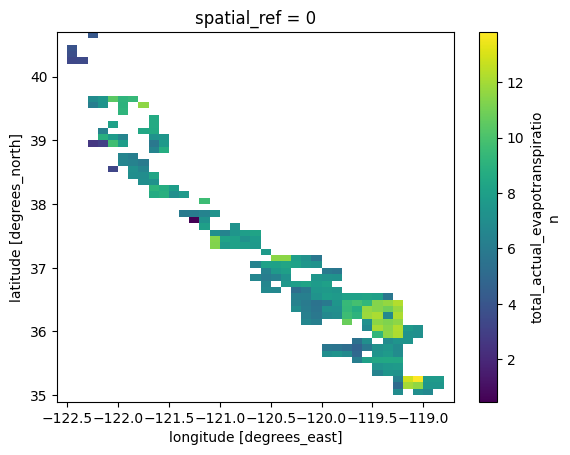

In [11]:

ET_total_actual["total_actual_evapotranspiration"].mean(['time'], skipna=True).plot()

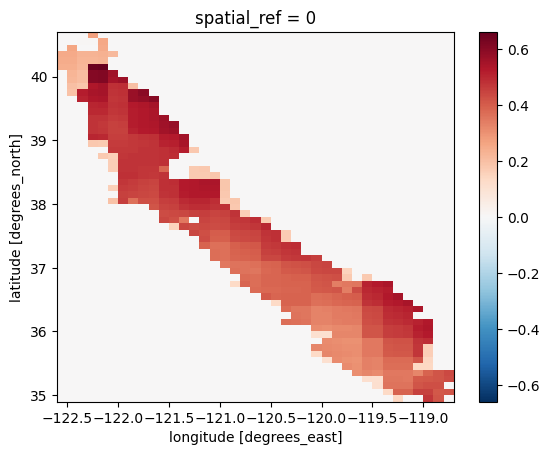

In [64]:
def sum_ignore_nan(a, b):
    summed = a + b
    summed = summed.where(~np.isnan(summed), other=a.fillna(0) + b.fillna(0)) 
    return summed

ddd = sum_ignore_nan(a = TRANSPIRATION_ADJUSTED_BUDYKO["transpiration_budyko"], b = EVAPORATION_ADJUSTED_BUDYKO["evaporation_budyko"])
# TRANSPIRATION_ADJUSTED["transpiration"] + EVAPORATION_ADJUSTED["evaporation"]
ddd.mean(['time'], skipna=True).plot()



# ddd_dataset["Actual_Evapotranspiration"].mean(['time'], skipna=True).plot()

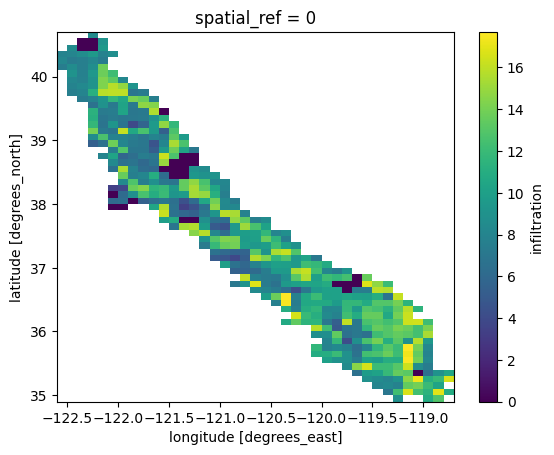

In [67]:
INFILTRATION["infiltration"].mean(['time'], skipna=True).plot()


In [18]:
DELTA_S["bilan"].sum(['time','lat','lon'], skipna=True).item()


-120578.57338628243

In [34]:
Pre["precipitation"][0]

<xarray.DataArray 'precipitation' (lat: 58, lon: 39)>
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan, 0.    , ...,    nan,    nan,    nan],
       [   nan, 0.    , 0.    , ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ..., 2.1875, 2.375 ,    nan],
       [   nan,    nan,    nan, ..., 0.875 , 1.0625, 1.25  ],
       [   nan,    nan,    nan, ..., 1.1875, 1.25  ,    nan]],
      dtype=float32)
Coordinates:
    time         object 2022-01-01 00:00:00
  * lon          (lon) float64 -122.5 -122.4 -122.3 ... -118.9 -118.8 -118.7
  * lat          (lat) float64 40.65 40.55 40.45 40.35 ... 35.15 35.05 34.95
    spatial_ref  int32 0
Attributes: (12/15)
    lat#long_name:            latitude
    lat#units:                degrees_north
    lat#_FillValue:           nan
    lon#long_name:            longitude
    lon#units:                degrees_east
    lon#_FillValue:           nan
    ...                       ...
    NETCDF_DIM_time_VALUES:   [44560. 44561. 44562. 44563. 44564. 44565. 4456...
    least_significant_digit:  1
    units:                    ('mm d-1', 'mm d-1', 'mm d-1', 'mm d-1', 'mm d-...
    scale_factor:             1.0
    add_offset:               0.0
    _FillValue:               -9999.0

In [38]:
Pre["precipitation"][0].mean(['lat', 'lon'], skipna=True).item()

ValueError: can only convert an array of size 1 to a Python scalar

In [37]:
Pre["precipitation"].mean(['time', 'lat', 'lon'], skipna=True).item()

0.6886433959007263

In [19]:
DELTA_S_BUDYKO["bilan_budyko"].sum(['time','lat','lon'], skipna=True).item()


14923168.497477865

In [13]:
soil_water_content_day[8][0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0., nan],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0., nan]])

In [12]:
IRRIGATION_REQUIREMENT_BUDYKO["irrigation_requirement_budyko"].sum(['time','lat','lon'], skipna=True).item()

14399142.52455752

In [43]:
DEEP_PERCOLATION.deepPercolation.sum(['time','lat','lon'], skipna=True).item()

315122.0752799677

In [16]:
from calendar import monthrange


df_1 = pd.DataFrame()
def get_days_in_month(row):
    return monthrange(int(row['year']), int(row['month']))[1]
i = 0
data_dir = 'D:\\mehdi\\DailyData\\export\\cal_budyko\csv\\'
for filename in os.listdir(data_dir):
    i += 1
    if filename.endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        
        fmt='%Y-%m-%d %H:%M:%S'
        df["time"] = df["time"].apply(lambda x : datetime.datetime.strptime(x, fmt))
        
        
        df["year"] = df["time"].apply(lambda x : x.year)
        df["month"] = df["time"].apply(lambda x : x.month)
        df["n_day"] = df.apply(lambda d : monthrange(int(d['year']), int(d['month']))[1], axis=1)
        list_col = list(df.columns)
        dict_agg = {i: "mean" for i in list_col if i not in ["year", "month" , "time", "lon", "lat", "spatial_ref"]}
        df = df.groupby(["year" , "month"]).agg(dict_agg).reset_index()
        for key, value in dict_agg.items():
            df[key] = df[key] * df["n_day"]
        df_1 = pd.concat([df_1, df])
        
        

KeyError: 'n_day'

In [15]:

df_1.to_csv('D:\\mehdi\\DailyData\\export\\cal_budyko\monthly_parameter.csv')

In [ ]:
data_dir = 'D:\\mehdi\\DailyData\\export\\ill\\'
output_dir = 'D:\\mehdi\\DailyData\\export\\csv\\'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(data_dir):
    
    if filename.endswith('.nc'):
        filepath = os.path.join(data_dir, filename)
        
        ds = xr.open_dataset(filepath)
        
        name_variable = filename.split('.')[0]
        year = filename.rsplit('_', 1)[-1].split('.')[0]
        
        ds.to_dataframe().to_csv(f"{output_dir}{name_variable}_{year}.csv")
        
        # for var in ds.data_vars:
        #     csv_filename = os.path.join(output_dir, var + '.csv')
        #     ds[var].to_dataframe().to_csv(csv_filename)

In [ ]:
filename

In [ ]:
filename.rsplit('_', 1)[-1].split('.')[0]

In [ ]:

name_part = filename.split('_')[2]
name_part